In [1]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from wordcloud import WordCloud
import numpy as np
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from collections import Counter
import nltk

We will read the .csv file for all the types of political debates since 1960 to 2020.

In [4]:
pd.options.mode.chained_assignment = None
path = '/Users/nikhil/data/ML_examples/erdos/'

speech_data = pd.read_csv('finaldata_party.csv')
speech_data.head()

,Unnamed: 0,speaker,text,type,election_year,date,candidate,result,party
0,0,John Kennedy,I uh – said that Ive served this country for f...,Pres,1960.0,1960-10-21,1.0,1,D
1,1,John Kennedy,"Mr. Howe, Mr. Vice President. First uh – let m...",Pres,1960.0,1960-10-21,1.0,1,D
2,2,Richard Nixon,"Mr. Howe, Senator Kennedy, my fellow Americans...",Pres,1960.0,1960-10-21,1.0,0,R
3,3,John Kennedy,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,1,D
4,4,Richard Nixon,"Good evening, Mr. Howe.",Pres,1960.0,1960-10-21,1.0,0,R


Lets define the column transformer class. The column traansformer will have parameters like min_date, max_date and type. You can specify the values of the dates for wich you wish to selectt the data. You can further specify the type of debate you wish to select (Presedintial, Vice Presidential, Democratic, Republican). If you want to use all the data for all dates and types, you caan specify 'None' for these parameters. We are only going to consider the debates for Democratic and Republican parties and ignore other parties. The column transformer will output a target varibale caalled 'party' which will be 0 for Republican and 1 for Democratic.

In [6]:
class Custom_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self,min_date,max_date,type):
        '''
        Inputs: 
        min_date: Select the start date, format: "YYYY-MM-DD",(if None selects all dates)
        max_date: Select the end date, format: "YYYY-MM-DD",(if None selects all dates)
        type: List of debate types, e.g ['VP','Pres','Dem','Rep'],(if None all types will be considered)
        
        Output:
        Debate Date, Debate Type selected data frame which contains only the 'Democratic' and 'Republican' party debates
        with targets 0 for 'Republican' and 1 for 'Democratic'
        '''
        self.min_date = min_date
        self.max_date = max_date
        self.type = type
        
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if self.min_date!=None and self.max_date!=None:
            X['date'] = pd.to_datetime(X['date'])
            date_mask = (X['date'] > self.min_date) & (X['date'] <= self.max_date)
            masked_data = X.loc[date_mask]
        else:
            masked_data = X
    
        if self.type!=None:
            masked1_data = masked_data.loc[masked_data['type'].isin(self.type)]
        else:
            masked1_data = masked_data
        masked2_data = masked1_data.loc[masked_data['party'].isin(['R','D'])]
        masked2_data.loc[masked2_data['party'] == 'R', 'party'] = 0
        masked2_data.loc[masked2_data['party'] == 'D', 'party'] = 1
        masked2_data['party'] = masked2_data['party'].astype(int)
        return masked2_data

Lets transform the original data frame and name it as df_new. Lets perform some exploratory data analysis. The function get_party_word_cloud runs the tf-idf vectorizer on the debates text for both the parties (Rep & Dem) and generates an output of word lists. These word lists include common words occuring in the debate text of both the parties as well as words that are unique to both the parties.

In [7]:
#Set True for bigrams otherwise set False for unigrams
Transformer = Custom_Transformer(min_date='1999-01-01',max_date='2022-01-01',type=['VP', 'Pres']) 
df_new = Transformer.fit_transform(speech_data)
   
def get_party_word_cloud(df_new):
    Text_democratic = df_new[df_new['party']==1]['text']
    Text_republican = df_new[df_new['party']==0]['text']
    Tfidf_D = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf_R = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf_R.fit_transform(Text_republican)
    Tfidf_D.fit_transform(Text_democratic)
    words_D = Tfidf_D.get_feature_names_out()
    words_R = Tfidf_R.get_feature_names_out()
    common_words = []
    unique_words_D =[]
    unique_words_R =[]
    for w in words_D:
        if w in words_R:
           common_words.append(w)
        else:
           unique_words_D.append(w)
    for w in words_R:
        if w not in common_words:
           unique_words_R.append(w)
    unique_alpha_words_R = []
    unique_alpha_words_D = []
    unique_alpha_words_C = []
    for w in unique_words_R:
        if w.isalpha():
           unique_alpha_words_R.append(w)
    for w in unique_words_D:
        if w.isalpha():
           unique_alpha_words_D.append(w)
    for w in common_words:
        if w.isalpha():
           unique_alpha_words_C.append(w)
    wc1 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_D))
    wc2 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_R))
    wc3 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(unique_alpha_words_C))
    return wc1,wc2,wc3,unique_alpha_words_D,unique_alpha_words_R,unique_alpha_words_C

wc1_unique,wc2_unique,wc3_unique,unique_words_D,unique_words_R,unique_words_C = get_party_word_cloud(df_new)

In [9]:
Counter(df_new['party'])

Counter({1: 1825, 0: 2092})

Lets see word cloud for the unique words that occur in debate text for both the parties as well as the common words that occur in both of them. We have removed all those words that contain numbers.

In [6]:
'''f = plt.figure(figsize=(400,200))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)

ax1.imshow(wc1_unique)
ax1.set_xlabel('Democratic Unique',fontsize=650)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2_unique)
ax2.set_xlabel('Republican Unique',fontsize=650)
ax2.set_xticks([])
ax2.set_yticks([])

ax3.imshow(wc3_unique)
ax3.set_xlabel('Common',fontsize=650)
ax3.set_xticks([])
ax3.set_yticks([])

plt.tight_layout()'''

"f = plt.figure(figsize=(400,200))\nax1 = f.add_subplot(221)\nax2 = f.add_subplot(222)\nax3 = f.add_subplot(223)\n\nax1.imshow(wc1_unique)\nax1.set_xlabel('Democratic Unique',fontsize=650)\nax1.set_xticks([])\nax1.set_yticks([])\n\nax2.imshow(wc2_unique)\nax2.set_xlabel('Republican Unique',fontsize=650)\nax2.set_xticks([])\nax2.set_yticks([])\n\nax3.imshow(wc3_unique)\nax3.set_xlabel('Common',fontsize=650)\nax3.set_xticks([])\nax3.set_yticks([])\n\nplt.tight_layout()"

Asuming that the words used during the debate reflect the party ideology, our aim is to build a classifier so that given a new sentence of words (representing some ideology), we should be able to predict which party will favour it. We will use the Multinomial Naive Bayes classifier. But first lets remove all numeric words from our data set. The function get_numeric_words collects all the numeric words appearing in the text and adds it to the english stop words list of the tf-idf vectorizer.

In [7]:
def get_numeric_words(df_new):
    all_Text = df_new['text']
    Tfidf = sk_text.TfidfVectorizer(lowercase=True,analyzer='word',stop_words='english',ngram_range=(1,1))
    Tfidf.fit_transform(all_Text)
    all_words = Tfidf.get_feature_names_out()
    numeric_words = []
    for w in all_words:
        if not w.isalpha():
           numeric_words.append(w)
    return numeric_words

candidates = df_new['speaker'].unique()
candidate_names = []
for w in candidates:
    for a in w.split():
        candidate_names.append(a.lower())

moderators = ['Dorothy Ridings', 'Sander Vanocur', 'John Mashek', 'Jack White',
       'Norma Quarles', 'Robert Boyd', 'Jim Lehrer', 'Ann Compton',
       'Moderator', 'Martha Raddatz', 'Bill Shadel', 'Frank McGee',
       'Charles Van Fremd', 'Douglass Cater', 'Rosco Drummond',
       'Bernard Shaw', 'Margaret Warner', 'Andrea Mitchell', 'Hal Bruno',
       'Bob Schieffer', 'Carol Simpson',
       'Kate Kelly', 'Gary Johnson', 'Bernie Sanders', 'Howard Smith',
       'Walter Cronkite', 'Candy Crowley', 'Audience', 'Helen Thomas',
       'Gene Gibbons', 'Chris Wallace', 'Quincy Howe', 'Frank Singiser',
       'John Edwards', 'John Chancellor', 'Edwin Newman', 'Georgie Geyer',
       'Marvin Kalb', 'Morton Kondracke', 'Barbara Walters',
       'Joseph Kraft', 'Robert Maynard', 'Jack Nelson', 'Marvin Stone',
       'Harry Ellis', 'William Hilliard', 'Elaine Quijano',
       'Judy Woodruff', 'Jon Margolis', 'Tom Brokaw', 'Brit Hume',
       'Gwen Ifill', 'Pauline Frederick', 'Max Frankel', 'Henry Trewitt',
       'Richard Valeriani', 'Paul Niven', 'Edward Morgan', 'Alvin Spivak',
       'Harold Levy', 'James Wieghart', 'Dianne Sawyer', 'Fred Barnes',
       'Charles Gibson', 'Anderson Cooper', 'John Anderson',
       'Bill Moyers', 'Carol Loomis', 'Daniel Greenberg',
       'Charles Corddry', 'Lee May', 'Washington Post', 'Bryant Quinn',
       'New York Times', 'Soma Golden', 'Frank Reynolds', 'James Gannon',
       'Elizabeth Drew', 'Anne Groer', 'Peter Jennings', 'Bob Fleming',
       'Stuart Novins', 'Charles Warren', 'Voiceover', 'Lester Holt',
       'Franchesca Ramsey', 'Connor Franta', 'Marques Brownlee',
       'Dana Bash', 'Don Lemon', 'Juan Carlos Lopez', 'David Muir',
       'Neil Levesque', 'Josh McElveen', 'Rachel Maddow',
       'Kristen Welker', 'Ashley Parker', 'Erin Burnett', 'Marc Lacey',
       'Jake Tapper', 'Marrianne Williamson', 'John King',
       'Nia-Malika Henderson', 'Michael Bennet', 'crowd',
       'George Stephanopoulos', 'Jorge Ramos', 'Lindsey Davis',
       'Wolf Blitzer', 'Abby Phillip', 'Brianne Pfannenstiel',
       'Hallie Jackson', 'Chuck Todd', 'Vanessa Hauc', 'Jon Ralston',
       'Protestors', 'Tim Alberta', 'Amna Nawaz', 'Yamiche Alcindor',
       'Savannah Guthrie', 'Jose Diaz', 'Steve Kornacki', 'Lindsey David',
       'Monica Hernandez', 'Adam Sexton', 'Linsey Davis', 'Devin Dwyer',
       'Rachel Scott', 'Announcer', 'Steve King', "Norah O'Donnell",
       'Candidate', 'Bill Whitaker', 'Major Garrett', 'Margaret Brennan',
       'Ilia Caldern', 'Sanjay Gupta', 'Amy Langenfeld', 'David Gergen',
       'Erick Erickson', 'Michelle Bachmann', 'Jim Demint',
       'Unidentified', 'Resident', 'Bret Baier', 'Gerald Seib',
       'Kelly Evans', 'Brian Williams', 'Shannon Bream', 'Rick Scott',
       'Maria Bartiromo', 'John Harwood', 'Jim Cramer', 'Steve Liesman',
       'Narrator', 'Doug Oberhelman', 'Rick Santelli', 'Sharon Epperson',
       'Matt Strawn', 'Hugh Hewitt', 'Susan Page ']

moderator_names = []
for name in moderators:
    for a in name.split():
        moderator_names.append(a.lower())
        

stop_words = stopwords.words('english')
numeric_words = get_numeric_words(df_new)
custom_stopwords = stop_words + numeric_words + candidate_names + moderator_names
# print(custom_stopwords)

The words above are our custom stop words and will be romved from the fit. Now we will define the tf-idf vectorizer (using ngrams = (1,1) for unigrams and ngrams = (2,2) for bigrams)

In [8]:
bigrams = False
if bigrams:
   ngrams = (2,2)
else:
   ngrams = (1,1)

Tfidf = sk_text.TfidfVectorizer(max_features=500,lowercase=True,analyzer='word',stop_words=custom_stopwords,ngram_range=(1,4))

We will first separate the data set df_new into test aand train data. Then we will separate the X and y for training and test data set. X is the 'text' column and y is the 'party' column.

In [9]:
df_new_train,df_new_test = train_test_split(df_new.copy(),test_size=0.3, random_state=42,stratify=df_new['party'])
X = df_new_train['text']
y = df_new_train['party']
X_test = df_new_test['text']
y_test = df_new_test['party']
Tfidf.fit_transform(df_new_train['text'])

c:\users\mirad\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['donnell', 'malika', 'malley', 'nia', 'rourke'] not in stop_words.
  warnings.warn(


<4826x500 sparse matrix of type '<class 'numpy.float64'>'
	with 69054 stored elements in Compressed Sparse Row format>

Lets generate a pipeline called Paarty_classifier. The pipeline will initially convert the 'text' column from the input data to a sparse matrix of words using the tf-idf vectorizer and feed that sparse matrix to sklearn's Multinomial Naive Bayes estimator. The Pipeline function is very useful when we are dealing with huge NLP data sets which require a lot of preprocessing before feeding it to the model. The Pipeline function can also be used for hyper-parametrer tuning using MyGridSearchCV.

In [10]:
Party_classifier = Pipeline([("Tfidf vectorizer",Tfidf),("Multinomial NB",MultinomialNB())])

Fit the Party_classifier to the train data and make predictions on the test data. We will also maake predictions on train data to get some insighhts on over-fitting/under-fitting.

In [11]:
Party_classifier.fit(X,y)
y_predict = Party_classifier.predict(X_test)
y_predict_train = Party_classifier.predict(X)

Some metrics

c:\users\mirad\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.77      0.15      0.26      1326
           1       0.75      0.98      0.85      3500

    accuracy                           0.75      4826
   macro avg       0.76      0.57      0.55      4826
weighted avg       0.76      0.75      0.69      4826



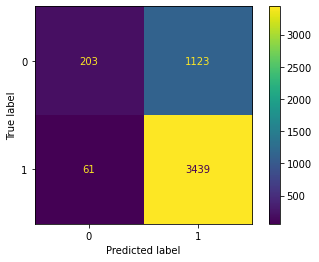

In [12]:
plot_confusion_matrix(Party_classifier, X, y)
print(classification_report(y, y_predict_train))

              precision    recall  f1-score   support

           0       0.72      0.12      0.21       568
           1       0.75      0.98      0.85      1501

    accuracy                           0.75      2069
   macro avg       0.74      0.55      0.53      2069
weighted avg       0.74      0.75      0.67      2069



c:\users\mirad\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


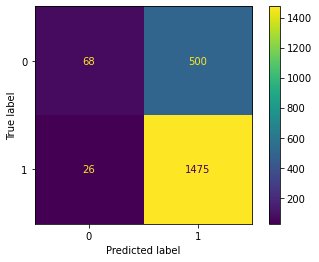

In [13]:
plot_confusion_matrix(Party_classifier, X_test, y_test)
print(classification_report(y_test, y_predict))

In [14]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, Party_classifier.predict_proba(X_test)[:,1])

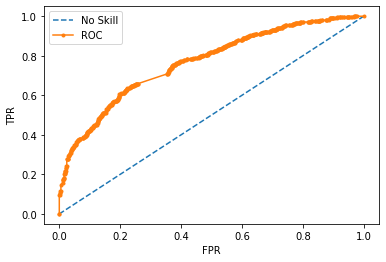

In [15]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label="ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [16]:
custom_test = ['We believe in democracy','Radical','Time to withdraw from syria','Russia is great','Climate change is real'
              ,'freedom','abortion is wrong','tax the rich','Recession could hit anytime','Housing','Strengthen our immigration policy','Block the borders']
y_custom = Party_classifier.predict_proba(custom_test)
prob_R = []
prob_D = []
for y in y_custom:
    prob_R.append(round(y[0],2)*100)
    prob_D.append(round(y[1],2)*100)
data_tuples = list(zip(custom_test,prob_R,prob_D))
output = pd.DataFrame(data_tuples, columns=['text','Probability of R', 'Probability of D'])
output

,text,Probability of R,Probability of D
0,We believe in democracy,14.0,86.0
1,Radical,27.0,73.0
2,Time to withdraw from syria,39.0,61.0
3,Russia is great,56.0,44.0
4,Climate change is real,5.0,95.0
5,freedom,27.0,73.0
6,abortion is wrong,52.0,48.0
7,tax the rich,19.0,81.0
8,Recession could hit anytime,27.0,73.0
9,Housing,27.0,73.0


During training, the multinomial naive bayes calculates probabilities such as $Pr(\textrm{'Great'}\ |\ \textrm{Win}),$ the probability that the word "Great" appears in the candidate's speech, given that the candidate has won the election.  Using these probabilities, we can define a **polarity score** for each word $w$,

$$\textrm{polarity}(w) = \log\left(\frac{Pr(w\ |\ \textrm{won})}{Pr(w\ |\ \textrm{lost})}\right).$$

Polarity analysis is an example where a simpler model (naive Bayes) offers more explicability than more complicated models.  Aside from this, naive Bayes models are easy to train, the training process is parallelizable, and these models lend themselves well to online learning.  Given enough training data, naive Bayes models have performed well in NLP applications such as spam filtering.

Speaking in terms of python code, the command  "**party_classifier['Tfidf vectorizer'].get_feature_names_out()**"  will give you a list of filtered words that were used as features in the multinomial naive bayes method. We can get **$\log(Pr(w\ |\ \textrm{won}))$** and **$\log(Pr(w\ |\ \textrm{lost}))$** by using the sklearn's "**model.feature_log_prob**" command as follows,

$\log(Pr(w\ |\ \textrm{won}))$ = classifier['Multinomial NB'].feature_log_prob_[1]

$\log(Pr(w\ |\ \textrm{lost}))$ = classifier['Multinomial NB'].feature_log_prob_[0]

Using this, we can calculate the polarity score for all the words.

Some of the words that the TF-IDF vectorizer uses as features are given below

In [17]:
words = Party_classifier['Tfidf vectorizer'].get_feature_names_out()

words[:50]

array(['ability', 'able', 'absolutely', 'across', 'act', 'actually',
       'administration', 'afford', 'affordable', 'african',
       'african american', 'ago', 'agree', 'agreement', 'allies', 'allow',
       'already', 'also', 'always', 'amendment', 'america', 'american',
       'american people', 'americans', 'another', 'answer', 'anybody',
       'anyone', 'anything', 'applause', 'around', 'around world', 'ask',
       'asked', 'assad', 'attack', 'away', 'back', 'bad', 'barack',
       'barack obama', 'beat', 'behind', 'believe', 'best', 'better',
       'big', 'biggest', 'billion', 'billionaires'], dtype=object)

In [18]:
def get_polar_words(classifier,top):
    coeff_pos = classifier['Multinomial NB'].feature_log_prob_[1]
    coeff_neg = classifier['Multinomial NB'].feature_log_prob_[0]
    words = classifier['Tfidf vectorizer'].get_feature_names_out()
    words_join=[]
    for w in words:
        words_join.append(w.replace(" ", "_"))
    words_join = np.array(words_join)
    polarity = coeff_pos-coeff_neg
    polarity_sorted = np.sort(polarity)
    index_sort = np.argsort(polarity)
    words_sorted = words_join[index_sort]
    words_positive = words_sorted[-top:]
    words_negative = words_sorted[:top]
    wc1 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_positive))
    wc2 = WordCloud(width = 1000, height = 500,background_color="white").generate(" ".join(words_negative))
    return wc1,wc2,words_join


Lets plot the top 50 most polar words

[]

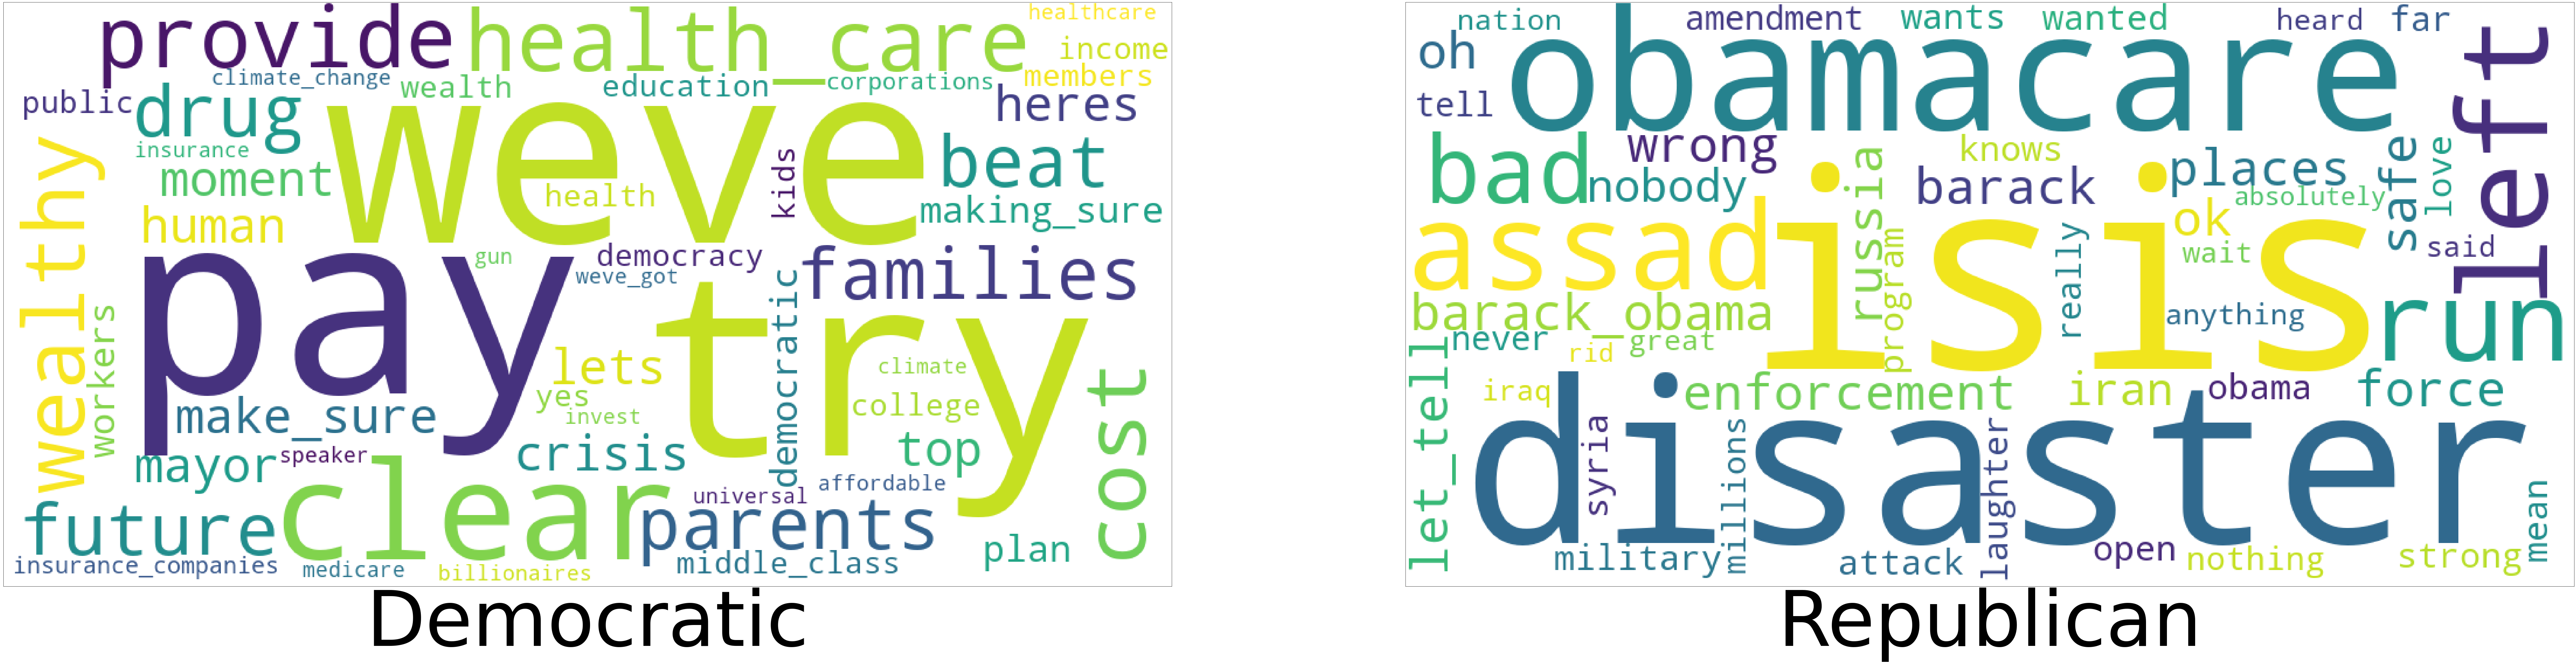

In [19]:
wc1,wc2,feature_names = get_polar_words(Party_classifier,50)

f = plt.figure(figsize=(150,50))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.imshow(wc1)
ax1.set_xlabel('Democratic',fontsize=250)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(wc2)
ax2.set_xlabel('Republican',fontsize=250)
ax2.set_xticks([])
ax2.set_yticks([])

